In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# 1) Carga
with open("../ataques_limpios.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print("Primeras filas:")
print(df.head())

In [ ]:
# 2) Limpieza / Transformación
# Eliminar columnas poco útiles para el modelo (texto libre, listas, identificadores)
df = df.drop(columns=["payload", "tools", "ip", "city"], errors="ignore")

In [ ]:
# Convertir timestamp (ms) -> datetime y luego a entero epoch (segundos)
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", errors="coerce")
df = df.dropna(subset=["timestamp"])  # asegurar timestamps válidos
df["ts_epoch"] = (df["timestamp"].astype("int64") // 10**9)

In [ ]:
# Codificar categóricas
label_encoders = {}
for col in ["protocol", "os", "behavior", "country"]:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

print("\nDatos transformados:")
print(df.head())


In [ ]:
# 3) Gráficas exploratorias (3)
plt.figure(figsize=(6, 4))
sns.countplot(x=df["protocol"])
plt.title("Distribución de Protocolos")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=df["os"])
plt.title("Distribución de Sistemas Operativos")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=df["country"])
plt.title("Ataques por País")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 4) Modelado: behavior como etiqueta
y = df["behavior"]
# Usamos variables numéricas útiles
feature_cols = [c for c in ["port", "protocol", "os", "country", "ts_epoch"] if c in df.columns]
X = df[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Modelo 1: Árbol de Decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
print("\n=== Árbol de Decisión ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

In [ ]:
# Modelo 2: Random Forest
forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

Primeras filas:
               ip  port protocol     os  \
0   36.16.227.141  3952      UDP  macOS   
1  205.227.72.227  2822     ICMP    iOS   
2   237.38.147.31  8740     ICMP    iOS   
3   191.27.70.151  6650      TCP  macOS   
4     71.8.70.175  7165     ICMP  macOS   

                                             payload                    tools  \
0  Error sed reiciendis tempora illo asperiores m...      [reboot, bandwidth]   
1                Vero aut nisi est aut autem libero.       [index, bandwidth]   
2                      Aut id doloremque quaerat ut.    [calculate, protocol]   
3  Tempore dolorem asperiores quam at perspiciati...     [override, protocol]   
4  Qui consequatur recusandae sunt consequatur no...  [compress, application]   

      behavior      timestamp                           country           city  
0          DOS  1741989596598                           Czechia      Brockside  
1      SPYWARE  1752091832129  Micronesia (Federated States of)     Feestmou

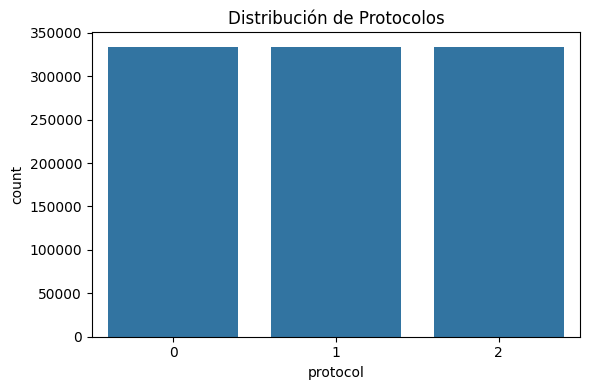

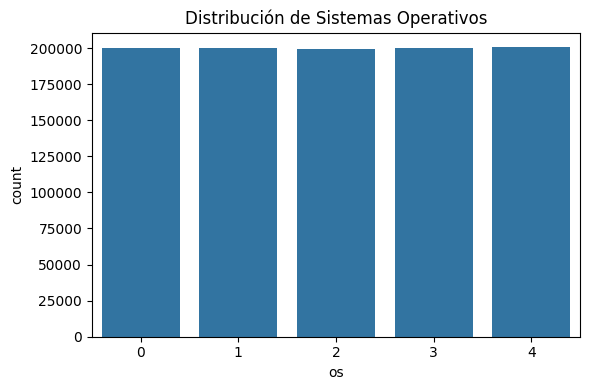

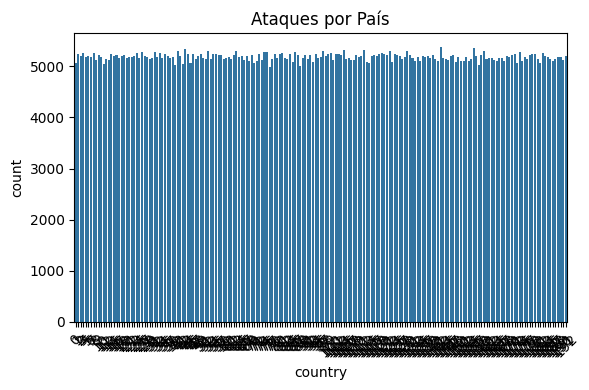


=== Árbol de Decisión ===
Accuracy: 0.24915779477182987
              precision    recall  f1-score   support

           0       0.25      0.25      0.25     50008
           1       0.25      0.25      0.25     49909
           2       0.25      0.25      0.25     50108
           3       0.25      0.25      0.25     50045

    accuracy                           0.25    200070
   macro avg       0.25      0.25      0.25    200070
weighted avg       0.25      0.25      0.25    200070



In [ ]:
# Modelo 3: Regresión Logística (multiclase)
log_model = LogisticRegression(max_iter=1000, multi_class="auto")
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("\n=== Regresión Logística ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
